# EDA 

In this competition, we are provided with DICOM images of chest X-ray radiographs, and we are asked to identify and localize COVID-19 abnormalities. This is important because typical diagnosis of COVID-19 requires molecular testing (polymerase chain reaction) requires several hours, while chest radiographs can be obtained in minutes, but it is hard to distinguish between COVID-19 pneumonia and other other viral and bacterial pneumonias. Therefore, in this competition, be hope to develop AI that that eventually help radiologists diagnose the millions of COVID-19 patients more confidently and quickly.


# Imports
Let's start out by setting up our environment by importing the required modules:

In [1]:
! conda install -c conda-forge gdcm -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py37h89c1867_0         141 KB  conda-forge
    conda-4.10.3               |   py37h89c1867_0         3.1 MB  conda-forge
    gdcm-2.8.9                 |   py37h5d359c0_2         3.4 MB  conda-forge
    libjpeg-turbo-2.1.0        |       h7f98852_0         987 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         7.7 MB

The following NEW packages will be INSTALLED:

  gdcm               conda-forge/linux-64::gdcm-2.8.9-py37h5d359c0_2
  libjpeg-turbo      conda-forge/linux-64::libjpeg-turbo-2.1.0-h7f98852_0

The following packages 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pydicom
import glob
from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import warnings
from fastai.vision.all import *
from fastai.medical.imaging import *
warnings.filterwarnings('ignore')

# A look at the provided data

Let's check what data is available to us:

In [3]:
dataset_path = Path('../input/siim-covid19-detection')

In [4]:
dataset_path.ls()

(#5) [Path('../input/siim-covid19-detection/sample_submission.csv'),Path('../input/siim-covid19-detection/train_image_level.csv'),Path('../input/siim-covid19-detection/test'),Path('../input/siim-covid19-detection/train'),Path('../input/siim-covid19-detection/train_study_level.csv')]

We can see that we have:

* `train_study_level.csv` - the train study-level metadata, with one row for each study, including correct labels.
* `train_image_level.csv` - the train image-level metadata, with one row for each image, including both correct labels and any bounding boxes in a dictionary format. Some images in both test and train have multiple bounding boxes.
* `sample_submission.csv` - a sample submission file containing all image- and study-level IDs.
* `train` folder - comprises 6,334 chest scans in DICOM format, stored in paths with the form `study`/`series`/`image`
* `test` folder - The hidden test dataset is of roughly the same scale as the training dataset.


# A look at the CSVs

Let's check the `train_study_level.csv` file:

In [5]:
train_study_df = pd.read_csv(dataset_path/'train_study_level.csv')

In [6]:
train_study_df.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


Let's look at the unique labels:

In [7]:
study_classes = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
np.unique(train_study_df[study_classes].values, axis=0)

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

As you can see, at the study-level, we are predicting the following classes:
* Negative for Pneumonia
* Typical Appearance
* Indeterminate Appearance
* Atypical Appearance

This here is a standard multi-label classification problem. In the training set, interestingly they are not multi-label, but it is mentioned that:
> Studies in the test set may contain more than one label.

Let's look at the distribution:


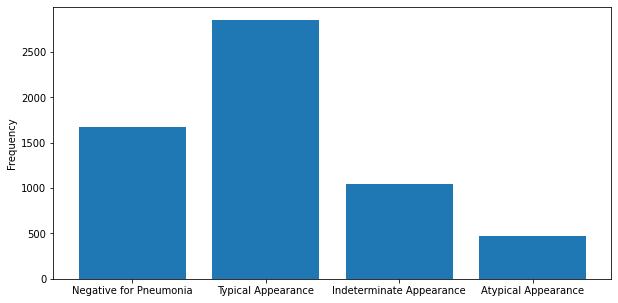

In [8]:
plt.figure(figsize = (10,5))
plt.bar([1,2,3,4], train_study_df[study_classes].values.sum(axis=0))
plt.xticks([1,2,3,4],study_classes)
plt.ylabel('Frequency')
plt.show()

Let's now look at `train_image_level.csv`:

In [9]:
train_image_df = pd.read_csv(dataset_path/'train_image_level.csv')

In [10]:
train_image_df.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e


We have our bounding box labels provided in the `label` column. The format is as follows:

`[class ID] [confidence score] [bounding box]`

* class ID - either `opacity` or `none`
* confidence score - confidence from your neural network model. If none, the confidence is `1`.
* bounding box - typical `xmin ymin xmax ymax` format. If class ID is none, the bounding box is `1 0 0 1 1`.

The bounding boxes are also provided in easily readable dictionary format in column `boxes`, and the study that each image is a part of is provided in`StudyInstanceUID`.

Let's quick look at the distribution of opacity vs none:

In [11]:
train_image_df['split_label'] = train_image_df.label.apply(lambda x: [x.split()[offs:offs+6] for offs in range(0, len(x.split()), 6)])

Text(0, 0.5, 'Frequency')

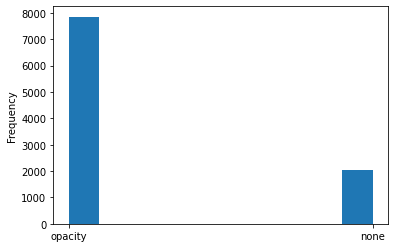

In [12]:
classes_freq = []
for i in range(len(train_image_df)):
    for j in train_image_df.iloc[i].split_label: classes_freq.append(j[0])
plt.hist(classes_freq)
plt.ylabel('Frequency')

Let's also look at the distribution of the bounding box areas:

Text(0, 0.5, 'Frequency')

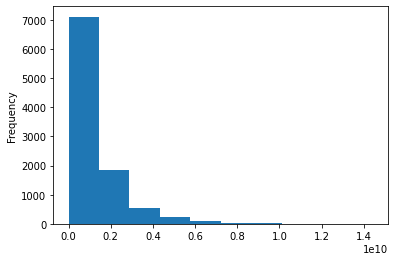

In [13]:
bbox_areas = []
for i in range(len(train_image_df)):
    for j in train_image_df.iloc[i].split_label:
        bbox_areas.append((float(j[4])-float(j[2]))*(float(j[5])*float(j[3])))
plt.hist(bbox_areas)
plt.ylabel('Frequency')

# A look at the images

Okay, let's now look at some example images:

In [14]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data
        
    
def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

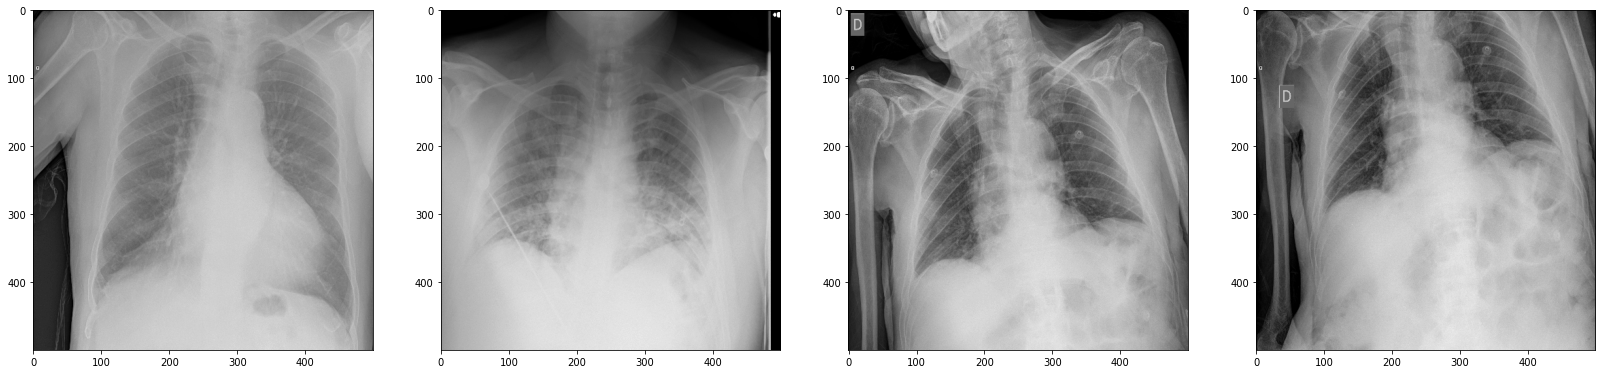

In [15]:
dicom_paths = get_dicom_files(dataset_path/'train')
imgs = [dicom2array(path) for path in dicom_paths[:4]]
plot_imgs(imgs)

Let's actually look at how many images are available per study:

In [16]:
num_images_per_study = []
for i in (dataset_path/'train').ls():
    num_images_per_study.append(len(get_dicom_files(i)))
    if len(get_dicom_files(i)) > 5:
        print(f'Study {i} had {len(get_dicom_files(i))} images')
    

Study ../input/siim-covid19-detection/train/8943d1d85097 had 6 images
Study ../input/siim-covid19-detection/train/0fd2db233deb had 9 images
Study ../input/siim-covid19-detection/train/a7335b2f9815 had 7 images


(array([5.822e+03, 2.070e+02, 1.500e+01, 4.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

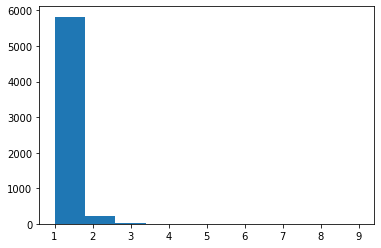

In [17]:
plt.hist(num_images_per_study)

In [18]:
def image_path(row):
    study_path = dataset_path/'train'/row.StudyInstanceUID
    for i in get_dicom_files(study_path):
        if row.id.split('_')[0] == i.stem: return i 
        
train_image_df['image_path'] = train_image_df.apply(image_path, axis=1)

../input/siim-covid19-detection/train/69e33b894532/8a32a9a9de36/262dc03560d6.dcm
../input/siim-covid19-detection/train/d715b966355d/3308819e0cb8/267f44ef1151.dcm
../input/siim-covid19-detection/train/6263c19334f8/1acf610fbe04/dfc7b258312f.dcm
../input/siim-covid19-detection/train/127ae57ae3a0/7e020d094610/78bd533aea35.dcm
../input/siim-covid19-detection/train/a4a423ac8d91/5c64dacb8b2b/dc233db14a5d.dcm
../input/siim-covid19-detection/train/e562c9ac6268/7dba451b56e0/c97d6fe880a7.dcm
../input/siim-covid19-detection/train/273cfc39402c/3403d6c0679a/a10ebe4a5522.dcm
../input/siim-covid19-detection/train/8783ec3cb07a/765c9ad4ab27/c4864d4d6114.dcm


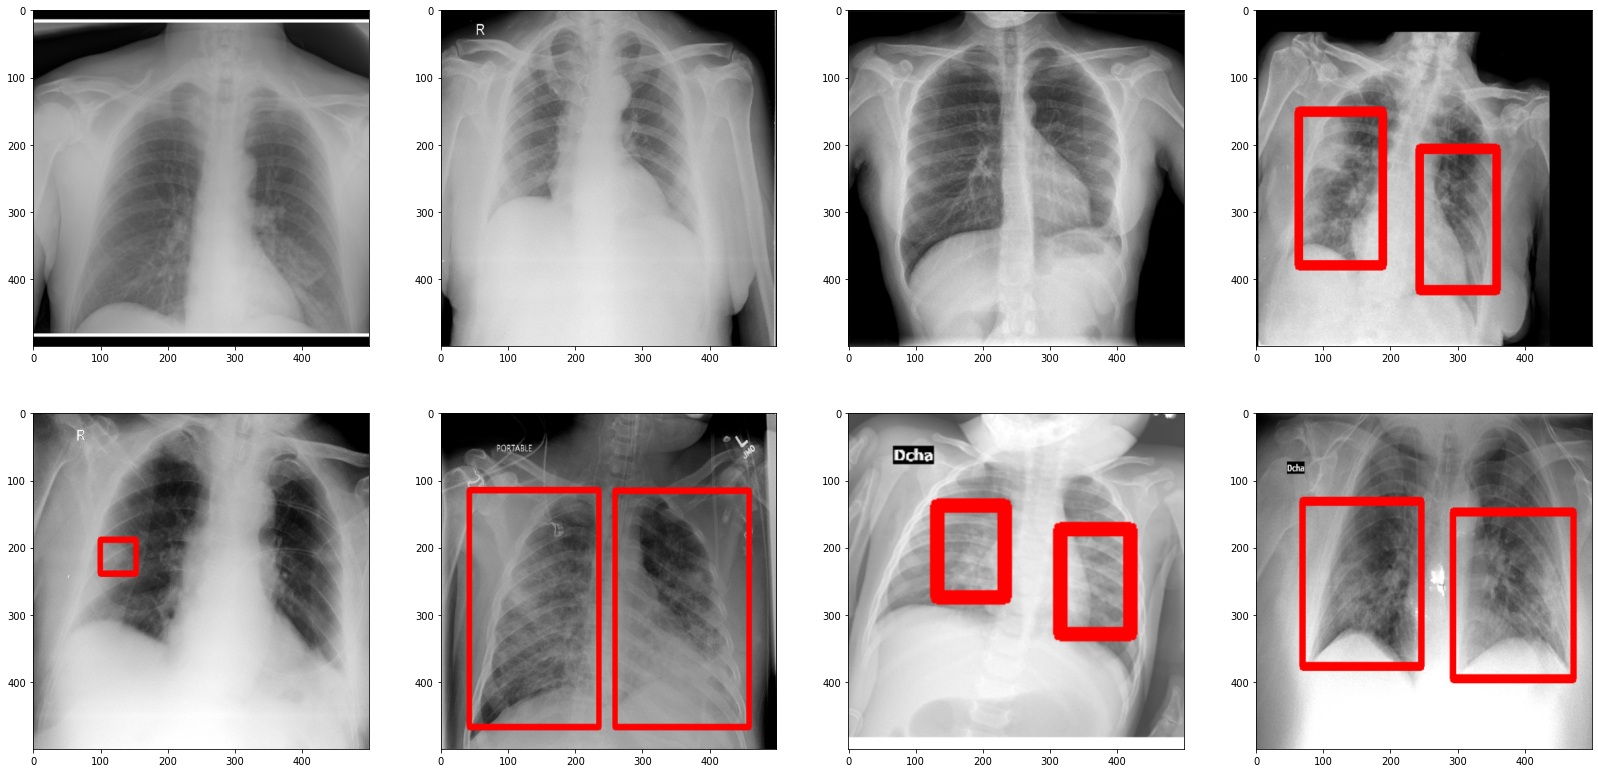

In [19]:
imgs = []
image_paths = train_image_df['image_path'].values

# map label_id to specify color
thickness = 10
scale = 5


for i in range(8):
    image_path = random.choice(image_paths)
    print(image_path)
    img = dicom2array(path=image_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    for i in train_image_df.loc[train_image_df['image_path'] == image_path].split_label.values[0]:
        if i[0] == 'opacity':
            img = cv2.rectangle(img,
                                (int(float(i[2])/scale), int(float(i[3])/scale)),
                                (int(float(i[4])/scale), int(float(i[5])/scale)),
                                [255,0,0], thickness)
    
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)